# Pan Fetal Immune - scVI 4 integration

In [3]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap


import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random

In [5]:
## import utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

## Load and prep data

In [7]:
data_dir = "/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/"
timestamp = "20210429"

### Load estimated gene dispersions for HVG selection

In [8]:
adata_lognorm_var = pd.read_csv(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.var.csv'.format(t=timestamp))

### Load count data

In [9]:
adata_raw = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.h5ad'.format(t=timestamp))
adata_raw.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
adata_raw

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name'
    var: 'GeneID', 'GeneName'

### Load obs with uniform labels

In [12]:
new_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv".format(t=timestamp), index_col=0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
adata_raw = adata_raw[new_obs.index]
adata_raw.obs = new_obs.copy()

In [15]:
adata_raw

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample'
    var: 'GeneID', 'GeneName'

In [16]:
import gc
gc.collect()

39589

Add dispersion estimates to `var`

In [17]:
adata_raw.var = adata_lognorm_var.copy()

### Add batch key
Here we concatenate library prep method and donor of origin

In [18]:
adata_raw.obs["bbk"] = adata_raw.obs["method"] + adata_raw.obs["donor"]

## Param sweep for feature selection

1. Number of HVGS
2. Excluding or not excluding TCR/BCR genes
3. Number of latent dimensions

In [20]:
import torch
device = torch.device("cuda")

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.data.setup_anndata(adata, batch_key = "bbk", copy=True)
    vae = scvi.model.SCVI(adata, n_latent=n_dims)
    vae.train(use_gpu=True, batch_size=256) ## increasing batch size as in retina atlas
    return(vae.get_latent_representation())
    
def save_scVI(adata, 
              timestamp,
              n_hvgs = 5000,
              remove_cc_genes = True,
                remove_tcr_bcr_genes = False,
                n_dims=20
             ):
    if remove_cc_genes:
        cc = "removeCC"
    else:
        cc = "keepCC"
    if remove_tcr_bcr_genes:
        tcr = "removeTCRBCR"
    else:
        tcr = "keepTCRBCR"
    outname = "PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.{h}HVGS.{cc}.{tcr}.{n}ldims.npy".format(t=timestamp, h=n_hvgs, cc=cc, tcr=tcr, n=n_dims)
    np.save(data_dir + outname, adata.obsm["X_scVI"])


In [17]:
nhvgs = [5000,7500,10000]
dims = [10,20,30]
remove = [{'remove_cc_genes':True, 'remove_tcr_bcr_genes':True}, {'remove_cc_genes':True, 'remove_tcr_bcr_genes':False}, {'remove_cc_genes':False, 'remove_tcr_bcr_genes':False}]

In [ ]:
for n in nhvgs:
    for r in remove:
        adata1 = prep_scVI(adata_raw, n_hvgs=n, remove_cc_genes=r["remove_cc_genes"], remove_tcr_bcr_genes=r["remove_tcr_bcr_genes"])
        for d in dims:
            
            adata1.obsm["X_scVI"] = train_scVI(adata1, n_dims=d)
            save_scVI(adata1, timestamp=timestamp, n_hvgs=n, remove_cc_genes=r["remove_cc_genes"], remove_tcr_bcr_genes=r["remove_tcr_bcr_genes"], n_dims=d)
        del adata1
        gc.collect()

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using batches from adata.obs["bbk"]                                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 911873 cells, 5000 vars, 33       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9/9: 100%|██████████| 9/9 [06:07<00:00, 40.83s/it, loss=807, v_num=1]


## Train reference
We train using parameters optimized for online update with `scArches`, to be able to add query datasets in the future. Following the [scvi-tools vignette](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scarches_scvi_tools.html?highlight=encode_covariates#Train-reference).

In [21]:
adata = prep_scVI(adata_raw, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
adata = scvi.data.setup_anndata(adata, batch_key = "bbk", copy=True)

In [94]:
arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae = scvi.model.SCVI(adata, n_latent=20, **arches_params)
vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [22:21<00:00,  3.35s/it, loss=1.15e+03, v_num=1]


### Check convergence

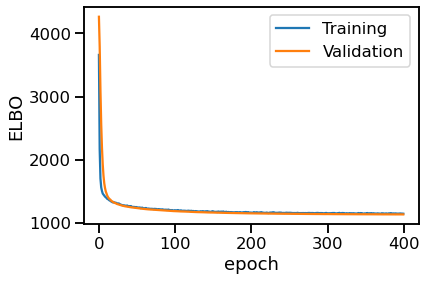

In [100]:
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");
plt.savefig("/home/jupyter/mount/gdrive/Pan_fetal/Updates_and_presentations/scvi_training_elbo.pdf", bbox_inches="tight")

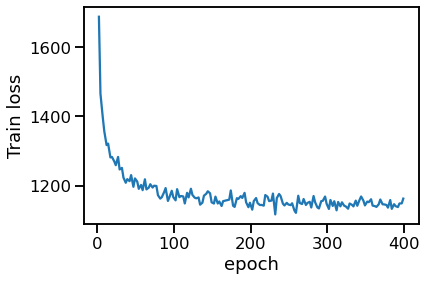

In [101]:
sns.set_context("talk")
plt.plot(vae.history["train_loss_step"], label="train");
# plt.plot(vae.history["reconstruction_loss_validation"], label="validation");
plt.xlabel("epoch");
plt.ylabel("Train loss");

In [102]:
## Save embedding
x_scvi = vae.get_latent_representation()
outname = "PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.npy".format(t=timestamp)
np.save(data_dir + outname, x_scvi)

In [103]:
## Save training stats
model_history = vae.history.copy()
model_history.pop('train_loss_step')
pd.DataFrame.from_dict({k:v[k] for k,v in model_history.items()}).to_csv("PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.train_history.csv".format(t=timestamp))

In [104]:
# save the reference model
model_dir = 'scvi_PFI_model/'
if not os.path.exists(data_dir + model_dir):
    os.mkdir(data_dir + model_dir)
vae.save(data_dir + model_dir, overwrite=True)